In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-kovppdpo
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-kovppdpo
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=25917aaf2a6a85ed104c0cd0a8eac23e29ac43bca5e2ca79a8024a07914c3a2f
  Stored in directory: /tmp/pip-ephem-wheel-cache-kr7cbtj0/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Conv2D,LeakyReLU,Conv2DTranspose,Activation,Concatenate
from keras.models import Model,Input 
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from numpy.random import randint
from numpy import ones,zeros

In [ ]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization


In [ ]:
# define discriminator model
# Structure is Convolution - InstanceNormalization - LeakyReLU
# C64-C128-C256-C512 

def define_discriminator(image_shape):

  init = RandomNormal(stddev=0.02)
  inp = Input(image_shape)

  #C64
  l1 = Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(inp)
  l1 = LeakyReLU(0.2)(l1)

  #C128
  l2 = Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(l1)
  l2 = InstanceNormalization(axis=-1)(l2)
  l2 = LeakyReLU(0.2)(l2)

  #C256
  l3 = Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(l2)
  l3 = InstanceNormalization(axis=-1)(l3)
  l3 = LeakyReLU(0.2)(l3)

  #C512
  l4 = Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(l3)
  l4 = InstanceNormalization(axis=-1)(l4)
  l4 = LeakyReLU(0.2)(l4)

  #C512
  l5 = Conv2D(256,(4,4),padding='same',kernel_initializer=init)(l4)
  l5 = InstanceNormalization(axis=-1)(l5)
  l5 = LeakyReLU(0.2)(l5)

  #patch output 
  l6 = Conv2D(1,(4,4),padding='same',kernel_initializer=init)(l5)

  #define model 
  model = Model(inp,l6)  

  #compile model
  model.compile(loss='mse',optimizer=Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])
  return model

In [ ]:
image_shape = (256,256,3)
model = define_discriminator(image_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# define resnet block 
def define_resnet_block(n_filters,inp_layer):
  init = RandomNormal(stddev=0.02)

  #first convolution layer
  l1 = Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(inp_layer)
  l1 = InstanceNormalization(axis=-1)(l1)
  l1 = Activation('relu')(l1)

  #second convolution layer
  l2 = Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(l1)
  l2 = InstanceNormalization(axis=-1)(l2)

  #Concatenate merge channel wise
  conc = Concatenate()([l2,inp_layer])

  return conc

In [ ]:
# define the generator model
# consists of downsampling blocks to encode the image
# resnet blocks to transform the image
# upsampling blocks to generate the output image
def define_generator(image_shape=(256,256,3),n_resnet=9):
  init = RandomNormal(stddev=0.02)
  input_layer = Input(image_shape)

  #C71-s
  l1 = Conv2D(64,(7,7),padding='same',kernel_initializer=init)(input_layer)
  l1 = InstanceNormalization(axis=-1)(l1)
  l1 = Activation('relu')(l1)

  #d128
  d1 = Conv2D(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(l1)
  d1 = InstanceNormalization(axis=-1)(d1)
  d1 = Activation('relu')(d1)

  #d256
  d2 = Conv2D(256,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(d1)
  d2 = InstanceNormalization(axis=-1)(d2)
  d2 = Activation('relu')(d2)

  #Resnet blocks
  for _ in range(n_resnet):
    d2 = define_resnet_block(256,d2)

  #u128
  u1 = Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(d2)
  u1 = InstanceNormalization(axis=-1)(u1)
  u1 = Activation('relu')(u1)

  #u256
  u2 = Conv2DTranspose(256,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(u1)
  u2 = InstanceNormalization(axis=-1)(u2)
  u2 = Activation('relu')(u2)

  #C7s1-3
  g = Conv2D(3,(7,7),padding='same',kernel_initializer=init)(u2)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('tanh')(g)

  #define model
  model = Model(input_layer,g)

  return model



In [ ]:
model = define_generator()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_4 (Insta (None, 256, 256, 64) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_4[0][0]   
____________________________________________________________________________________________

In [ ]:
# Implementing composite models and losses
# we will have 4 losses
# 1) adversial loss - the normal gan loss
# 2) Identity loss - passing and imageA to generatorA should just return imageA
# 3) forward cycle loss - output of gen1 to gen2 is provided and gen2 output is used to calc loss
# 4) backward cycle loss - output of gen2 to gen1 and gen1 output is used to calc loss

In [ ]:
# define a composite model for updating the generator model via adversial and cycle loss
def define_composite_model(g_model_1,d_model_1,g_model_2,image_shape):
  #mark the current generator model as trainable
  g_model_1.trainable = True

  #mark the discriminator model as non trainable
  d_model_1.trainable = False

  #mark the other generator model as non trainable
  g_model_2.trainable = False

  #discriminator loss - Input the output of generator model to it
  input_gen = Input(image_shape)
  gen1_output = g_model_1(input_gen)
  output_d = d_model_1(gen1_output)

  #Identity loss
  input_id = Input(image_shape)
  output_id = g_model_1(input_id)

  # forward cycle loss
  output_f = g_model_2(gen1_output)

  # backward cycle loss
  gen2_output = g_model_2(input_id)
  output_b = g_model_1(gen2_output)

  #define model graoh
  model = Model([input_gen,input_id],[output_d,output_id,output_f,output_b])
  #define optimizer 
  opt = Adam(lr=0.002,beta_1=0.05)
  #compile the model
  model.compile(loss=['mse','mae','mae','mae'],loss_weights=[1,5,10,10],optimizer=opt)

  return model

In [ ]:
#Updating the model weights

In [ ]:
#generated random images from the dataset
def generate_real_samples(dataset,n_samples,patch_shape):
  ix = randint(0,len(dataset),n_samples)
  #retrieve random images
  X = dataset[ix]
  #generate real class labels
  y = ones((n_samples,patch_shape,patch_shape,1))
  return X,y

In [ ]:
#generate fake samples
def generate_fake_samples(g_model,dataset,patch_shape):
  #generate images
  X = g_model.predict(dataset)
  #generate fake labels
  y = zeros((len(X),patch_shape,patch_shape,1))
  return X,y

In [ ]:
# The paper describes using a pool of previously generated images from which examples are randomly selected
# rather that using the images produced by the latest generator. 

In [ ]:
#update image pool for fake images
def update_image_pool(pool,images,max_size=50):
  selected = list()
  for img in images:
    if len(pool) < max_size:
      pool.append(img)
      selected.append(img)
    elif random() < 0.5:
      selected.append(img)
    else:
      #replace existing image and use replaced image
      ix = randint(0,len(pool))
      selected.append(pool[ix])
      pool[ix] = img
  
  return asarray(selected)

In [ ]:
from os import listdir
from numpy import vstack,asarray
from keras.preprocessing.image import img_to_array,load_img
from numpy import savez_compressed

In [ ]:
# load all images in a directory into memory
def load_images(path,size=(256,256,3)):
  data_list = list()
  for filename in listdir(path):
    #Load and resize the image
    pixels = load_img(path+filename,target_size=size)
    #convert to numpy array
    pixels = img_to_array(pixels)

    #store
    data_list.append(pixels)
  
  return asarray(data_list)


In [ ]:
path = '/content/drive/MyDrive/cycleGanData/'

#load apple data
trainDataApple = load_images(path + 'trainA/')
testDataApple = load_images(path + 'testA/')
dataA = vstack((trainDataApple,testDataApple))
print('Loaded dataA: ',dataA.shape)


#load orange data
trainDataOrange = load_images(path + 'trainB/')
testDataOrange = load_images(path + 'testB/')
dataB = vstack((trainDataOrange,testDataOrange))
print('Loaded dataB: ',dataB.shape)


filename = 'apple2Orange.npz'
savez_compressed(filename,dataA,dataB)
print('Saved dataset',filename)

Loaded dataA:  (1261, 256, 256, 3)
Loaded dataB:  (1267, 256, 256, 3)
Saved dataset apple2Orange.npz


Loaded:  (1261, 256, 256, 3) (1267, 256, 256, 3)


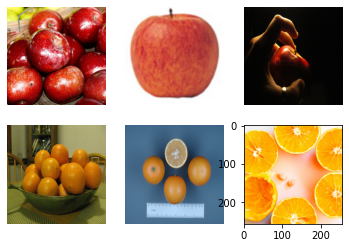

In [ ]:
from numpy import load
import matplotlib.pyplot as plt

data = load('/content/drive/MyDrive/apple2Orange.npz')
dataA, dataB = data['arr_0'],data['arr_1']
print('Loaded: ',dataA.shape,dataB.shape)
n_samples = 3

#plot apple images
for i in range(n_samples):
  plt.axis('off')
  plt.subplot(2,n_samples,i+1)
  plt.imshow(dataA[i].astype('uint8'))

#plot orange images
for i in range(n_samples):
  plt.axis('off')
  plt.subplot(2,n_samples,1+n_samples+i)
  plt.imshow(dataB[i].astype('uint8'))

plt.show()

In [ ]:
def load_real_samples(filename):
  #load the dataset
  data = load(filename)
  #unpack the data
  X1,X2 = data['arr_0'],data['arr_1']
  #scale from [0,255] to [-1,1]
  X1 = (X1-127.5)/(127.5)
  X2 = (X2-127.5)/(127.5)
  return [X1,X2]

In [ ]:
# As the generator and the discriminator model do not converge
# we need to find an equilibrium btw them

def save_model(step,g_model_AtoB,g_model_BtoA):
  #save the first generator model
  filename1 = 'g_model_AtoB%06d.h5' % (step+1)
  g_model_AtoB.save(filename1)

  #save the 2nd generator model
  filename2 = 'g_model_BtoA%06d.h5' % (step+1)
  g_model_AtoB.save(filename2)  

In [ ]:
#generate samples and save as a plot and save the model
def summarize_performance(step,g_model,trainX,name,n_samples=5):
  #select a sample of input images
  X_in,_ = generate_real_samples(trainX,n_samples,0)
  #generate translated images
  X_out,_ = generate_fake_samples(g_model,X_in,0)

  X_in = (X_in+1) / 2.0
  X_out = (X_out+1) / 2.0

  # plot real images
  for i in range(n_samples):
    plt.subplot(2,n_samples,i+1)
    plt.axis('off')
    plt.imshow(X_in[i])

  #plot translated images 
  for i in range(n_samples):
    plt.subplot(2,n_samples,i+1+n_samples)
    plt.axis('off')
    plt.imshow(X_out[i])
  
  #save plot 
  filename = '%s_generated_plot%06d.png' %(name,(step+1))
  plt.savefig(filename)
  plt.close()

In [ ]:
#Train cycleGan models
def train_gan(g_model_AtoB,g_model_BtoA,d_model_A,d_model_B,c_model_AtoB,c_model_BtoA,dataset):
  #properties for training
  n_epochs,n_batch = 100,1
  # determine the output shape of the discriminator
  n_patch = d_model_A.output_shape[1]
  #unpacking the dataset
  trainA,trainB = dataset

  #pool for fake images 
  poolA,poolB = list(),list()
  #batches per epoch
  batch_per_epoch = int(len(trainA)/n_batch)
  #Total no of steps
  n_steps = batch_per_epoch*n_epochs

  #manually enumerate epochs
  for i in range(n_steps):
    print('step',i)
    #select a batch of real samples
    X_realA,y_realA = generate_real_samples(trainA,n_batch,n_patch)
    X_realB,y_realB = generate_real_samples(trainB,n_batch,n_patch)

    #generate fake samples
    X_fakeA,y_fakeA = generate_fake_samples(g_model_BtoA,X_realA,n_patch)
    X_fakeB,y_fakeB = generate_fake_samples(g_model_AtoB,X_realB,n_patch)

    #update fake pool
    X_fakeA = update_image_pool(poolA,X_fakeA)
    X_fakeB = update_image_pool(poolB,X_fakeB)

    #update the generatorBtoA via the adversial and cycle loss
    g_loss2,_,_,_,_ = c_model_BtoA.train_on_batch([X_realB,X_realA],[y_realA,X_realA,X_realB,X_realA]) 

    #update discriminator A 
    daLoss1 = d_model_A.train_on_batch(X_realA,y_realA)
    daLoss2 = d_model_A.train_on_batch(X_fakeA,y_fakeA)

    #update the generatorBtoA via the adversial and cycle loss
    g_loss1,_,_,_,_ = c_model_AtoB.train_on_batch([X_realA,X_realB],[y_realB,X_realB,X_realA,X_realB]) 

    #update discriminator A 
    dbLoss1 = d_model_B.train_on_batch(X_realB,y_realB)
    dbLoss2 = d_model_B.train_on_batch(X_fakeB,y_fakeB)


    #evaluate the model performance
    if (i+1) % (batch_per_epoch) == 0:
      #plot A->B translation
      summarize_performance(i,g_model_AtoB,trainA,'AtoB')
      #plot B->A translation
      summarize_performance(i,g_model_BtoA,trainB,'BtoA')

    if (i+1) % (batch_per_epoch) == 0:
      save_model(i,g_model_AtoB,g_model_BtoA)


In [ ]:
dataset = load_real_samples('/content/drive/MyDrive/apple2Orange.npz')
print('Loaded',dataset[0].shape,dataset[1].shape)



Loaded (1261, 256, 256, 3) (1267, 256, 256, 3)


In [ ]:
#define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
#generator : A->B
gen_AtoB = define_generator()
#generator : B->A
gen_BtoA = define_generator()
#discriminator : A->[real/fake]
d_modelA = define_discriminator(image_shape)
#discriminator : B->[real/fake]
d_modelB = define_discriminator(image_shape)
#composite : A -> B -> [real/fake,A]
c_model_AtoB = define_composite_model(gen_AtoB,d_modelB,gen_BtoA,image_shape)
# composite : B-> A -> [real/fake,B]
c_model_BtoA = define_composite_model(gen_BtoA,d_modelB,gen_AtoB,image_shape)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#train models
train_gan(gen_AtoB,gen_BtoA,d_modelA,d_modelB,c_model_AtoB,c_model_BtoA,dataset)

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96


KeyboardInterrupt: ignored

In [ ]:
random()

0.24357519137861272